#Word2Vec implementation from scratch

1. Get text corpus, clean text;
2. Create N-grams;
3. Build W2V model;
4. Train model;
5. Visualisation.

In [1]:
!pip install git+https://github.com/PetrochukM/PyTorch-NLP.git

  Cloning https://github.com/PetrochukM/PyTorch-NLP.git to /tmp/pip-req-build-o6x7p_5c
  Running command git clone -q https://github.com/PetrochukM/PyTorch-NLP.git /tmp/pip-req-build-o6x7p_5c
  Created wheel for pytorch-nlp: filename=pytorch_nlp-0.5.0-py3-none-any.whl size=88361 sha256=b419b31398ae2e7be551b94629a80538e780a2065da1e43bccaa36c022e2cccb
  Stored in directory: /tmp/pip-ephem-wheel-cache-79h8tvf4/wheels/84/78/c4/66b0b0a3f3973609c6fdd26a91411257c13314b2445c7d83fc
Successfully built pytorch-nlp


In [2]:
from torchnlp.datasets import imdb_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
from bs4 import BeautifulSoup

## Get corpus and clean text

In [3]:
train = imdb_dataset(train=True)
train[:1]

aclImdb_v1.tar.gz: 84.1MB [00:07, 10.5MB/s]                            


[{'sentiment': 'pos',
  'text': 'Gene Kelly, Frank Sinatra, Kathryn Grayson, and Jose Iturbi star in "Anchors Aweigh," directed by George Sidney.<br /><br />Kelly and Sinatra are Joe and Clarence, two navy guys on leave in Hollywood. They meet a little boy (Dean Stockwell) and on taking him home, they meet his aunt (Grayson). Clarence falls for her. She wants an audition for Jose Iturbi. They try to help, but there\'s a mix-up.<br /><br />This is a very energetic musical with great dancing and singing by Kelly and Sinatra. Kelly gets to dance with Jerry the Mouse in a delightful sequence. Grayson sings Jalousie and My Heart Sings. Not one of my favorite voices, but she does well. Iturbi\'s piano work is beautiful.<br /><br />Sinatra gets to show his versatility and why the girls swooned over him, with those big blue eyes and boyish face. For Kelly, this was a major break for him at MGM.<br /><br />Wonderful movie, very buoyant.'}]

In [4]:
#create corpus with 'lines_number' number of lines
def create_corpus(dataset, lines_number):
  corpus = []
  for i, diction in enumerate(train):
    corpus.append(diction['text'])
    if i == lines_number - 1:
      return corpus

In [5]:
corpus = create_corpus(train, 50)

In [6]:
def clean_text(text):
    soup = BeautifulSoup(text)
    text = soup.get_text(separator=' ')
    clean_url = re.compile(r'https?://\S+|www\.\S+')
    text = re.sub(clean_url, ' ', text)
    clean_html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text_nohtml = re.sub(clean_html, ' ', text)
    clean_punctuation = re.compile(r'[^\w\s]')
    text_nopunct = re.sub(clean_punctuation, ' ', text_nohtml)
    clean_spaces = re.compile(r'\s+')
    text_nospaces = re.sub(clean_spaces, ' ', text_nopunct).strip()
    return text_nospaces.lower()

In [7]:
#clear text and lowercased it
corpus = [clean_text(sentence) for sentence in corpus]
corpus[:1]

['gene kelly frank sinatra kathryn grayson and jose iturbi star in anchors aweigh directed by george sidney kelly and sinatra are joe and clarence two navy guys on leave in hollywood they meet a little boy dean stockwell and on taking him home they meet his aunt grayson clarence falls for her she wants an audition for jose iturbi they try to help but there s a mix up this is a very energetic musical with great dancing and singing by kelly and sinatra kelly gets to dance with jerry the mouse in a delightful sequence grayson sings jalousie and my heart sings not one of my favorite voices but she does well iturbi s piano work is beautiful sinatra gets to show his versatility and why the girls swooned over him with those big blue eyes and boyish face for kelly this was a major break for him at mgm wonderful movie very buoyant']

In [8]:
#tokenize 
corpus = [sentence.split() for sentence in corpus]

In [9]:
# create vocabulary
vocabulary = set()
for sentence in corpus:
  vocabulary = vocabulary.union(set(sentence))
vocabulary = list(vocabulary)

In [10]:
len(vocabulary)

2866

In [11]:
#create dicts w2idx idx2w
word2idx = {word: i for i, word in enumerate(vocabulary)}
idx2word = {i: word for i, word in enumerate(vocabulary)}

## Create n-grams

In [12]:
#create list of bigrams
window_size = 2
bigrams = []
words = []
for sentence in corpus:
  length = len(sentence)
  for i, word in enumerate(sentence):
    start_index = 0 if i - window_size <= 0 else i - window_size
    end_index = length - 1 if i + window_size > length - 1 else i + window_size 
    for idx in range(start_index, end_index + 1):
      if idx != i:
        bigrams.append([word2idx[sentence[i]], word2idx[sentence[idx]]])
        words.append([sentence[i],sentence[idx]])

In [13]:
bigrams[:10]

[[1444, 2256],
 [1444, 802],
 [2256, 1444],
 [2256, 802],
 [2256, 808],
 [802, 1444],
 [802, 2256],
 [802, 808],
 [802, 2532],
 [808, 2256]]

In [14]:
words[20:40]

[['grayson', 'jose'],
 ['and', 'kathryn'],
 ['and', 'grayson'],
 ['and', 'jose'],
 ['and', 'iturbi'],
 ['jose', 'grayson'],
 ['jose', 'and'],
 ['jose', 'iturbi'],
 ['jose', 'star'],
 ['iturbi', 'and'],
 ['iturbi', 'jose'],
 ['iturbi', 'star'],
 ['iturbi', 'in'],
 ['star', 'jose'],
 ['star', 'iturbi'],
 ['star', 'in'],
 ['star', 'anchors'],
 ['in', 'iturbi'],
 ['in', 'star'],
 ['in', 'anchors']]

## Create model and train

In [15]:
class Word2Vec(nn.Module):
  def __init__(self, embedding_size, vocabulary: list):
      super().__init__()
      self.embedding_size = embedding_size
      self.vocabulary = vocabulary
      self.vocabulary_size = len(self.vocabulary)
      self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size)
      self.hidden = nn.Linear(self.embedding_size, self.vocabulary_size, bias=False)

      initrange = 0.5 / self.embedding_size
      self.embedding.weight.data.uniform_(-initrange, initrange)
      self.hidden.weight.data.uniform_(0, 0)


  def get_input_layer(self, word_idx):
    x = torch.zeros(self.vocabulary_size).type(torch.LongTensor)
    x[word_idx] = 1.0
    return x

  def forward(self, batch):
        #word_onehot = self.get_input_layer(batch[0])
        word_onehot = torch.LongTensor(batch[0])
        return self.hidden(self.embedding(word_onehot))

  def init_emb(self):
      """
      init the weight as original word2vec do.
      """
      initrange = 0.5 / self.embembedding_size_dim
      self.encoder.weight.data.uniform_(-initrange, initrange)
      self.decoder.weight.data.uniform_(0, 0)

  def get_word_emdedding(self, word, word2idx):
        # word = torch.tensor([word2idx[word]])
        # word = self.get_input_layer(word)
        word = torch.LongTensor([word2idx[word]])
        return self.embedding(word)


In [16]:
def random_batch(skip_grams, batch_size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(skip_grams[i][0])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

In [17]:
type(random_batch(bigrams, 5)[1])

list

In [20]:
epoch = 10000
batch_size = 50
model = Word2Vec(300, vocabulary)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch_num in range(epoch):
    #batch = bigrams[step_idx]
    batch = random_batch(bigrams, batch_size)
    optimizer.zero_grad()
    output = model(batch)
    #loss = criterion(output, model.get_input_layer(batch[1]))
    loss = criterion(output, torch.LongTensor(batch[1]))

    if epoch_num % 1000 == 0:
        print('Step:', '%04d' % (epoch_num), 'cost =', '{:.6f}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()

Step: 0000 cost = 7.960671
Step: 1000 cost = 6.813868
Step: 2000 cost = 6.025949
Step: 3000 cost = 6.073544
Step: 4000 cost = 5.200054
Step: 5000 cost = 5.856451
Step: 6000 cost = 5.115308
Step: 7000 cost = 5.594199
Step: 8000 cost = 4.871279
Step: 9000 cost = 4.977201


In [21]:
embedding = model.get_word_emdedding('colors', word2idx)

In [23]:
len(embedding[0])

300

## Visualize

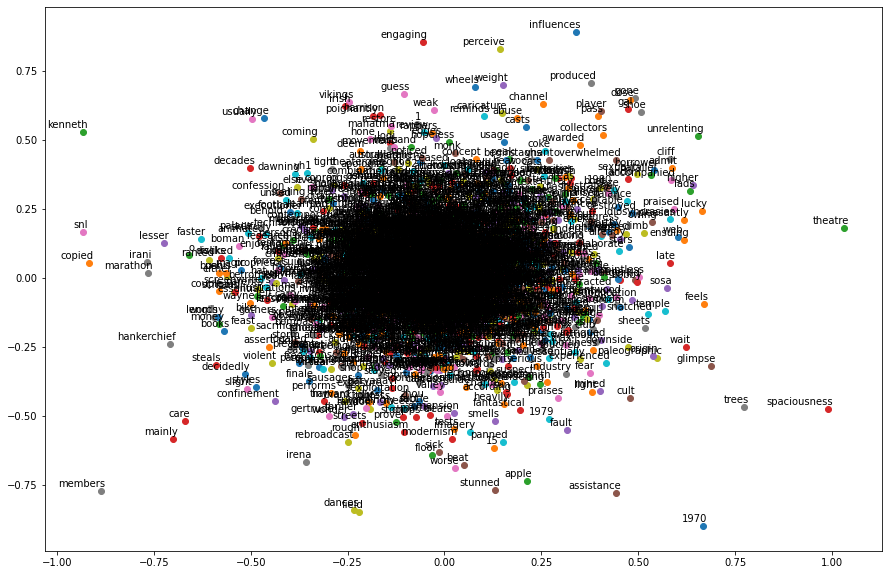

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
for w in vocabulary:
    x = model.get_word_emdedding(w, word2idx).detach().data.numpy()[0][0]
    y = model.get_word_emdedding(w, word2idx).detach().data.numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
#from bs4 import BeautifulSoup

class Word2Vec(nn.Module):
  def __init__(self, embedding_size, vocabulary: list):
    super().__init__()
    self.embedding_size = embedding_size
    self.vocabulary = vocabulary
    self.vocabulary_size = len(self.vocabulary)
    self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size)
    self.hidden = nn.Linear(self.embedding_size, self.vocabulary_size, bias=False)

    initrange = 0.5 / self.embedding_size
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.hidden.weight.data.uniform_(0, 0)


  def get_input_layer(self, word_idx):
    x = torch.zeros(self.vocabulary_size).type(torch.LongTensor)
    x[word_idx] = 1.0
    return x

  def forward(self, batch):
    #word_onehot = self.get_input_layer(batch[0])
    word_onehot = torch.LongTensor(batch[0])
    return self.hidden(self.embedding(word_onehot))

  def init_emb(self):
    """
    init the weight as original word2vec do.
    """
    initrange = 0.5 / self.embembedding_size_dim
    self.encoder.weight.data.uniform_(-initrange, initrange)
    self.decoder.weight.data.uniform_(0, 0)

  def get_word_emdedding(self, word, word2idx):
    # word = torch.tensor([word2idx[word]])
    # word = self.get_input_layer(word)
    word = torch.LongTensor([word2idx[word]])
    return self.embedding(word)

def clean_text(text):
  # soup = BeautifulSoup(text)
  # text = soup.get_text(separator=' ')
  clean_url = re.compile(r'https?://\S+|www\.\S+')
  text = re.sub(clean_url, ' ', text)
  clean_html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  text_nohtml = re.sub(clean_html, ' ', text)
  clean_punctuation = re.compile(r'[^\w\s]')
  text_nopunct = re.sub(clean_punctuation, ' ', text_nohtml)
  clean_spaces = re.compile(r'\s+')
  text_nospaces = re.sub(clean_spaces, ' ', text_nopunct).strip()
  return text_nospaces.lower()

def random_batch(skip_grams, batch_size):
  random_inputs = []
  random_labels = []
  random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

  for i in random_index:
    random_inputs.append(skip_grams[i][0])  # target
    random_labels.append(skip_grams[i][1])  # context word
    return random_inputs, random_labels

def train(data: str):
  #clear text
  corpus = [clean_text(sentence) for sentence in [data]]
  #tokenize it
  corpus = [sentence.split() for sentence in corpus]
  # create vocabulary
  vocabulary = set()
  for sentence in corpus:
    vocabulary = vocabulary.union(set(sentence))
  vocabulary = list(vocabulary)
  #create dicts w2idx idx2w
  word2idx = {word: i for i, word in enumerate(vocabulary)}
  idx2word = {i: word for i, word in enumerate(vocabulary)} 
  #create list of bigrams
  window_size = 3
  bigrams = []
  words = []
  for sentence in corpus:
    length = len(sentence)
    for i, word in enumerate(sentence):
      start_index = 0 if i - window_size <= 0 else i - window_size
      end_index = length - 1 if i + window_size > length - 1 else i + window_size 
      for idx in range(start_index, end_index + 1):
        if idx != i:
          bigrams.append([word2idx[sentence[i]], word2idx[sentence[idx]]])
          words.append([sentence[i],sentence[idx]])
  #train the model
  epoch = 7000
  batch_size = 5
  model = Word2Vec(600, vocabulary)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  for epoch_num in range(epoch):
    #batch = bigrams[step_idx]
    batch = random_batch(bigrams, batch_size)
    optimizer.zero_grad()
    output = model(batch)
    #loss = criterion(output, model.get_input_layer(batch[1]))
    loss = criterion(output, torch.LongTensor(batch[1]))

    if epoch_num % 1000 == 0:
      print('Step:', '%04d' % (epoch_num), 'cost =', '{:.6f}'.format(loss))

    loss.backward(retain_graph=True)
    optimizer.step()  

  #create final dict
  embedding_dict = {}
  for word in vocabulary:
    embedding = model.get_word_emdedding(word, word2idx)
    np_embedding = embedding[0].detach().numpy()
    embedding_dict[word] = np_embedding
  return embedding_dict

In [24]:
d = 'This movie is now appearing on digital TV at least once a month, I\'ve watched it a dozen or more times, and it never ceases to delight me. If it was on tomorrow I\'d watch it again. Such is the artistry that Peter Ustinov and Maggie Smith, two great magicians of the acting profession can create, helped in no small way by the superb supporting trio of Karl Malden, Bob Newhart and Robert Morley. Not forgetting others in minor roles.<br /><br />It is a simple tale, simply told, of an ex-con, a lovable embezzler, battling and succeeding with the then "new age technology" i.e computers, and finding affection in the process. Even if it is a tad (tongue in cheek) implausible, even unbelievable, the characters are not. There is no violence, no sex, no bad language, and best'
emb = train(d)